<a href="https://colab.research.google.com/github/mansurimn/MLselflearning/blob/main/MNIST_Autoencode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training data shape: (60000, 784)
Test data shape: (10000, 784)
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.3281 - val_loss: 0.1399
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1310 - val_loss: 0.1108
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1092 - val_loss: 0.1008
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1009 - val_loss: 0.0957
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0956 - val_loss: 0.0919
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0923 - val_loss: 0.0893
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0898 - val_loss: 0.0873
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0880 - val_loss: 0.0856
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0861 - val_loss: 0.0841
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0846 - val_loss: 0.0829
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


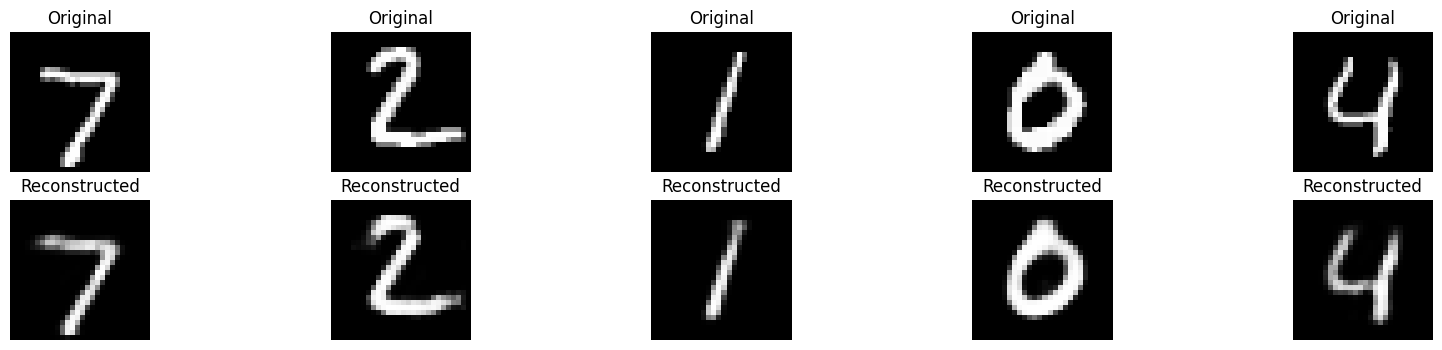

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten images (28x28 -> 784)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

# 2. Define Autoencoder
input_dim = x_train.shape[1]  # 784

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)   # compressed representation

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Compile
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# 3. Train Autoencoder
history = autoencoder.fit(
    x_train, x_train,  # input = output
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# 4. Test the model
reconstructed = autoencoder.predict(x_test)

# 5. Visualization: show original and reconstructed images
n = 5  # number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()
